In [8]:
# from google.colab import drive
import os
# drive.mount("/content/drive")
# !git clone https://github.com/JerryBHuang/s2021sv_torch.git
!ls


flower_data  README.md
rm: cannot remove 'flower_data.rar': No such file or directory
rm: cannot remove 'flower_data.zip': No such file or directory


In [11]:

import json

import time
import copy
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch import sum, max, save
from torch import cuda
from torch import optim
from torch import set_grad_enabled
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch.utils.data import DataLoader
import os.path
print(cuda.is_available())

data_dir = "./flower_data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
########数据预处理########

### 数据增强 Data Augmentation
# 解决数据不够的问题
# 更加高效利用数据
# 例如：翻转，旋转，缩放
data_transforms = {
    "train": transforms.Compose([transforms.Resize(256), # 统一大小
        transforms.RandomRotation(45),# 随机旋转，-45°~45°内随机选
        transforms.CenterCrop(224), # 把外圈裁掉，留下224*224的区域（中心）
        transforms.RandomHorizontalFlip(p=0.5), # 水平翻转，选择一个概率，0.5表示50%翻转，50%不翻转
        transforms.RandomVerticalFlip(p=0.5), # 垂直翻转
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        ),
        # brightness 亮度
        # contrast 对比度
        # saturation 饱和度
        # hue 色相
        transforms.RandomGrayscale(p=0.25), # 把25%的变换成灰度图
        transforms.ToTensor(), # 转换成tensor格式
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]), # 标准化（均值和标准差，模型要求的）
    ]),

    "valid": transforms.Compose([transforms.Resize(256), # 不需要进行数据增强，预处理一下就行了
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
}



batch_size = 3
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# 执行预处理操作，并制作dataset
image_data = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in image_datasets}
train_data = image_data["train"]
valid_data = image_data["valid"]

# 做mini batch
data_size = {x: len(image_datasets[x]) for x in image_data}
class_names = image_datasets['train'].classes
# print(image_datasets)
# print(image_data)
# print(data_size)

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    # 数据是（颜色通道，x，y）格式的，
    # 要把它改成（x，y，颜色通道）格式才能展示
    image = image * np.array([0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

def draw():
    fig = plt.figure(figsize=(20, 12))

    data = iter(image_data["valid"])
    inps, classes = data.next() # 取一个batch

    with open('cat_to_name.json', 'r') as f:
        labels = json.load(f)

    for idx in range(4 * 2):
        ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
        ax.set_title(labels[str(int(class_names[classes[idx]]))])
        plt.imshow(im_convert(inps[idx]))
    plt.show()


########迁移学习########
## 冻住一部分，剩下自己写

model_name = "resnet"
feature_extract = True # 是否使用别人训练好的特征
train_on_gpu = cuda.is_available() # 是否用gpu计算
device = "cuda:0" if train_on_gpu else "cpu"

def set_parameter_rg(model, fe): # 冻住所有层
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False


def initalize_resnet(num_classes, feature_extract, use_pretained=True):
    model_ft = models.resnet34(pretrained=use_pretained, ) # 加载模型
    set_parameter_rg(model_ft, feature_extract) # 冻住
    num_ftrs = model_ft.fc.in_features
    linear = nn.Sequential( # 重新定义全连接，改成102分类
        nn.Linear(num_ftrs, num_classes),
        nn.LogSoftmax(dim=1), # 用于算损失，不用交叉熵了
    )
    model_ft.fc = linear
    input_size = 224
    return model_ft, input_size


model_ft, inp_size = initalize_resnet(102, feature_extract, )
model = model_ft.to(device) # gpu
filename = "checkpoint.pth"

# 是否训练所有层
params = model_ft.parameters()
print("Params to train:")
if feature_extract:
    params = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

optimizer_ft = optim.Adam(params, lr=1e-2) # 1e-2 0.01 1e-3 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
# 每8个epoch衰减1/10的学习率
criterion = nn.NLLLoss() # 损失函数
# CrossEntropyLoss = LogSoftmax + NLLLoss

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,filename=filename):
    since = time.time()
    best_acc = 0

    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = max(outputs, 1) # 把概率最大的找出



                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs






True


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



Params to train:
	 fc.0.weight
	 fc.0.bias


In [12]:
model, valid_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(
    model=model_ft,
    dataloaders=image_data,
    criterion=criterion,
    optimizer=optimizer_ft,
    num_epochs=10,
)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Time elapsed 2m 14s
train Loss: 10.2135 Acc: 0.2079
Time elapsed 2m 25s
valid Loss: 5.6166 Acc: 0.5428
Optimizer learning rate : 0.0100000

Epoch 1/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time elapsed 4m 38s
train Loss: 9.6096 Acc: 0.3501
Time elapsed 4m 49s
valid Loss: 5.6555 Acc: 0.6088
Optimizer learning rate : 0.0100000

Epoch 2/9
----------
Time elapsed 7m 1s
train Loss: 9.4589 Acc: 0.4077
Time elapsed 7m 11s
valid Loss: 6.4074 Acc: 0.6149
Optimizer learning rate : 0.0100000

Epoch 3/9
----------
Time elapsed 9m 25s
train Loss: 9.4147 Acc: 0.4438
Time elapsed 9m 36s
valid Loss: 6.2570 Acc: 0.6467
Optimizer learning rate : 0.0100000

Epoch 4/9
----------
Time elapsed 11m 49s
train Loss: 9.3745 Acc: 0.4681
Time elapsed 11m 59s
valid Loss: 5.7669 Acc: 0.6907
Optimizer learning rate : 0.0100000

Epoch 5/9
----------
Time elapsed 14m 13s
train Loss: 9.0713 Acc: 0.4962
Time elapsed 14m 24s
valid Loss: 6.2114 Acc: 0.6980
Optimizer learning rate : 0.0100000

Epoch 6/9
----------
Time elapsed 16m 39s
train Loss: 9.2538 Acc: 0.4948
Time elapsed 16m 50s
valid Loss: 6.0833 Acc: 0.7029
Optimizer learning rate : 0.0100000

Epoch 7/9
----------
Time elapsed 19m 4s
train Loss: 9.1

### 把冻住的化掉,继续训练

In [19]:
import torch
for param in model.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(params, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

checkpoint = torch.load(filename)
best_acc = checkpoint["best_acc"]
model_ft.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])


In [20]:


model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(
    model_ft, image_data, criterion, optimizer, num_epochs=8)

Epoch 0/7
----------
Time elapsed 2m 40s
train Loss: 9.0672 Acc: 0.5368
Time elapsed 2m 50s
valid Loss: 6.5754 Acc: 0.7298
Optimizer learning rate : 0.0100000

Epoch 1/7
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Time elapsed 5m 28s
train Loss: 9.2018 Acc: 0.5453
Time elapsed 5m 39s
valid Loss: 5.4787 Acc: 0.7457
Optimizer learning rate : 0.0100000

Epoch 2/7
----------
Time elapsed 8m 18s
train Loss: 9.4211 Acc: 0.5467
Time elapsed 8m 29s
valid Loss: 5.5404 Acc: 0.7592
Optimizer learning rate : 0.0100000

Epoch 3/7
----------
Time elapsed 11m 8s
train Loss: 9.1431 Acc: 0.5583
Time elapsed 11m 18s
valid Loss: 5.0685 Acc: 0.7800
Optimizer learning rate : 0.0100000

Epoch 4/7
----------
Time elapsed 13m 57s
train Loss: 9.1615 Acc: 0.5658
Time elapsed 14m 7s
valid Loss: 9.2817 Acc: 0.6748
Optimizer learning rate : 0.0100000

Epoch 5/7
----------
Time elapsed 16m 46s
train Loss: 9.6753 Acc: 0.5582
Time elapsed 16m 57s
valid Loss: 6.6162 Acc: 0.7482
Optimizer learning rate : 0.0100000

Epoch 6/7
----------
Time elapsed 19m 36s
train Loss: 9.5153 Acc: 0.5664
Time elapsed 19m 46s
valid Loss: 6.5189 Acc: 0.7469
Optimizer learning rate : 0.0100000

Epoch 7/7
----------
Time elapsed 22m 25s
train Loss: 9

### 加载模型并预测

In [22]:
from torch import load
model_ft, input_size = initalize_resnet(102, feature_extract, True)
model_ft = model_ft.to(device)
filename = "checkpoint.pth"
checkpoint = torch.load(filename)
best_acc = checkpoint["best_acc"]
model_ft.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [41]:
from PIL import Image
def process_image(img_path):
  img = Image.open(img_path)
  ## Resize（变形）
  ## thumbnail只支持缩小，所以进行判断
  if img.size[0]>img.size[1]:
    img.thumbnail((10000, 256))
  else:
    img.thumbnail((256, 10000))

  ## Crop（裁减）
  ## 224x224
  marginleft = (img.width-224)/2 # 四个方向的边距
  marginbottom = (img.height-224)/2
  marginright = marginleft + 224
  margintop = marginbottom + 224
  img = img.crop((marginleft, marginbottom, marginright, margintop))

  ## Other
  img = np.array(img)/255 # 归一化，全部变成0~1之间的值
  mean = np.array([0.485, 0.456, 0.406]) # 均值
  std = np.array([0.229, 0.224, 0.225]) # 标准差

  ## torch里颜色通道在最前面，所以要特别注意
  img = img.transpose((2, 0, 1))

  return img

def imshow(image, title="Flower"):
  image = np.array(image).transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406]) # 均值
  std = np.array([0.229, 0.224, 0.225]) # 标准差
  image = std*image+mean # 还原
  plt.title(title)
  plt.imshow(image)
  plt.show()

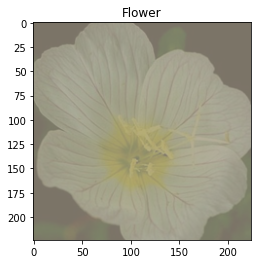

In [42]:
img_path = os.path.join(valid_dir, "1", "image_06739.jpg")
image = process_image(img_path)
imshow(image)

In [54]:
dataiter = iter(image_data["valid"])
imgs, labels = dataiter.next() # 取一个batch
imgs, labels = dataiter.next()

model_ft.eval()
if train_on_gpu:
  output = model_ft(imgs.cuda())
else:
  output = model_ft(imgs)


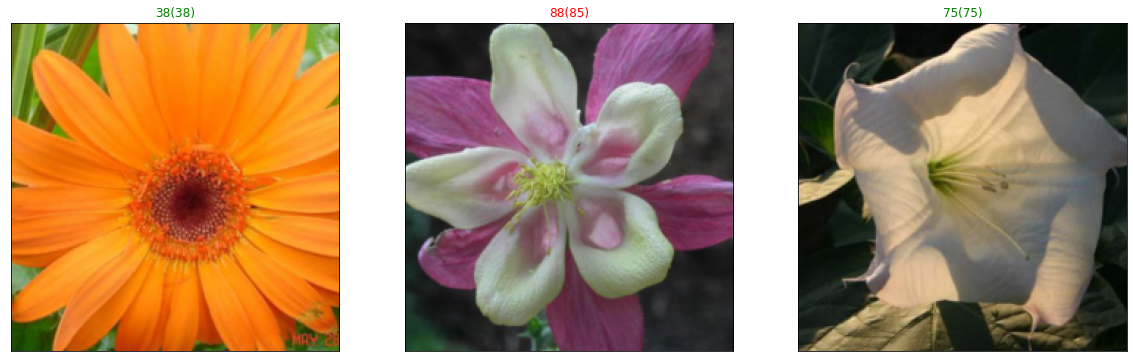

In [56]:
_, preds_tensor = torch.max(output, 1)
preds = np.array(preds_tensor.numpy()) if not train_on_gpu else np.array(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(20, 20))
for idx in range(3):
  ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(imgs[idx]))
 # ax.set_title("{}({})".format( cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx])] ), color = "green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx])] else "red")
  ax.set_title("{}({})".format(str(preds[idx]), str(int(labels[idx]))), color = "green" if str(preds[idx])==str(int(labels[idx])) else "red")